# CSGO - Predicting winning team of rounds

### Game Introduction - CSGO

Counter-Strike: Global Offensive (CSGO) is a first-person shooter that has become a global phenomenon and one of the hallmarks of the esport world. 

**GAME OBJECTIVE:**

In Competitive Demolition Mode, two teams of 5 players each battle each: the Terrorists and the Counter-Terrorists.
- As a Terrorist you are tasked with eliminating the opposition or planting the C4 bomb before the round time limit is reached and securing its detonation.
- As a Counter-Terrorist you are tasked with eliminating the opposition, defusing the bomb if planted, or stalling the Terrorist attack long enough until the round time limit is reached.  

**GAME LENGHT:**

Matches are played as over a maximum of 30 rounds, the first team to secure 16 rounds wins the game. At the end of the 15th round the two teams switch sides.

In regular matchmaking, if both teams secure 15 rounds then the match ends in a tie, however, in professional play and competitive leagues, the match will continue to an overtime.

**GAME ECONOMICS:**

Players start out a match with a specified amount, and will receive more as the match goes on by getting kills or going for the objectives. Money can then be used at the start of rounds to buy weapons and equipment, any residual money is taken over to the next round (reset at side-switch) to a maximum of $16000.

---

### Data Sources

Primary first hand data (directly from CSGO developer Valve Corporation) were unobtainable due to GDPR.

Thus secondary hand data had to be made use of. I've utilized as a foundation the data found in this Kaggle [dataset](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage) dating from 2018, covering just over 1400 competitive matchmaking matches. The data here was at the time extracted from competitive matchmaking replays submitted to csgo-stats.

### Lexicon

**file:**
*the file name that the demo was scraped from. This is a unique field for each match.*

**map:**
*the Valve official map the match was played on.*

**date:**
*date the match was played (unverified if they are correct).*

**round:**
*the round that the duel took place.*

**tick:**
*the current tick in the demo the entry took place. A tick is represented as a state in the game, Valve's competitive matchmaking sets every match at 64 ticks which represents that there are 64 states within each second of the game.*

**seconds:**
*the converted tick to seconds within the game since match start.*

**att_team:**
*the team that the attacking player is on that dealt damage to the victim. Usually Team 1 and 2 but in some recorded pro matches, can have custom team name e.g Games Academy.*

**vic_team:**
*the team that the victim player is on that received damage from the attacker.*

**att_side:**
*the side that the attacker was on. Can be Terrorist or CounterTerrorist.*

### Importing the tools

In [1]:
### Importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Importing the data

In [3]:
df = pd.read_csv('mm_master_demos.csv', index_col=0)

In [4]:
df.shape

(955466, 32)

In [5]:
df.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0


In [6]:
#Checking which maps we have data for
df['map'].value_counts()

de_mirage       267436
de_dust2        217505
de_cache        175796
de_inferno      121401
de_overpass      60071
de_cbble         49615
de_train         26343
de_nuke          10741
cs_office         5263
de_thrill         3623
cs_agency         3204
de_canals         3178
de_vertigo        2571
de_austria        1520
cs_assault        1501
cs_italy          1356
de_dust           1340
de_shipped         979
cs_insertion       875
de_blackgold       603
de_aztec           545
Name: map, dtype: int64

In [76]:
#our goal is to focus on one map.
#In this case we are going to look at de_mirage as being the most well popular map in the CSGO community
df = df[df.map == 'de_mirage']
df['map'].value_counts()

de_mirage    267436
Name: map, dtype: int64

### Exploring and cleaning the data

In [77]:
# NaN and dtype check
df.info()
# "bomb_site" presents only a value in case "is_bomb_planted" is TRUE.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267436 entries, 0 to 309
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   file             267436 non-null  object 
 1   map              267436 non-null  object 
 2   date             267436 non-null  object 
 3   round            267436 non-null  int64  
 4   tick             267436 non-null  int64  
 5   seconds          267436 non-null  float64
 6   att_team         267436 non-null  object 
 7   vic_team         267436 non-null  object 
 8   att_side         267436 non-null  object 
 9   vic_side         267436 non-null  object 
 10  hp_dmg           267436 non-null  int64  
 11  arm_dmg          267436 non-null  int64  
 12  is_bomb_planted  267436 non-null  bool   
 13  bomb_site        45420 non-null   object 
 14  hitbox           267436 non-null  object 
 15  wp               267436 non-null  object 
 16  wp_type          267436 non-null  object 

In [78]:
# checking the categorical data
df_cat = df.select_dtypes("object")
df_cat.head()

,file,map,date,att_team,vic_team,att_side,vic_side,bomb_site,hitbox,wp,wp_type,winner_team,winner_side,round_type
0,003218553373129179487_1555113029.dem,de_mirage,09/28/2017 8:44:36 PM,Team 1,Team 2,CounterTerrorist,Terrorist,NaN,Head,USP,Pistol,Team 2,Terrorist,PISTOL_ROUND
1,003218553373129179487_1555113029.dem,de_mirage,09/28/2017 8:44:36 PM,Team 2,Team 1,Terrorist,CounterTerrorist,NaN,Stomach,Glock,Pistol,Team 2,Terrorist,PISTOL_ROUND
2,003218553373129179487_1555113029.dem,de_mirage,09/28/2017 8:44:36 PM,Team 2,Team 1,Terrorist,CounterTerrorist,NaN,Head,Glock,Pistol,Team 2,Terrorist,PISTOL_ROUND
3,003218553373129179487_1555113029.dem,de_mirage,09/28/2017 8:44:36 PM,Team 1,Team 2,CounterTerrorist,Terrorist,NaN,Head,USP,Pistol,Team 2,Terrorist,PISTOL_ROUND
4,003218553373129179487_1555113029.dem,de_mirage,09/28/2017 8:44:36 PM,Team 2,Team 1,Terrorist,CounterTerrorist,NaN,Head,USP,Pistol,Team 2,Terrorist,PISTOL_ROUND


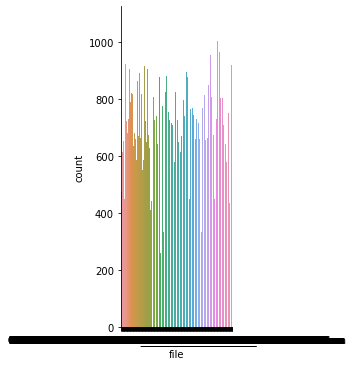

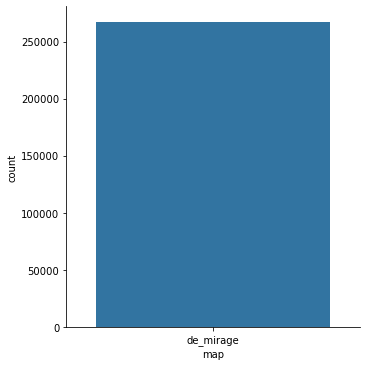

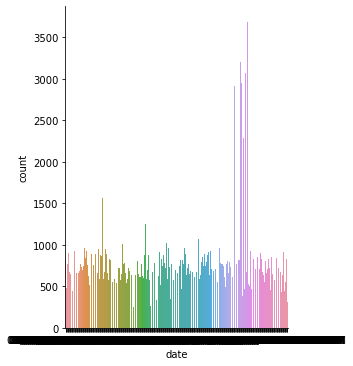

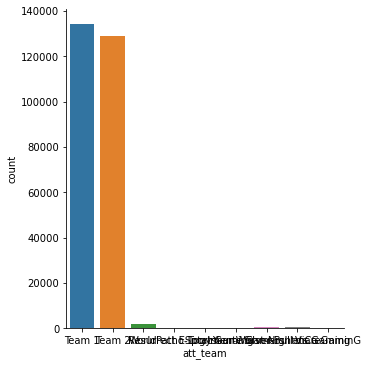

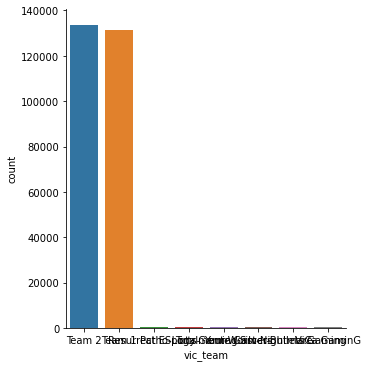

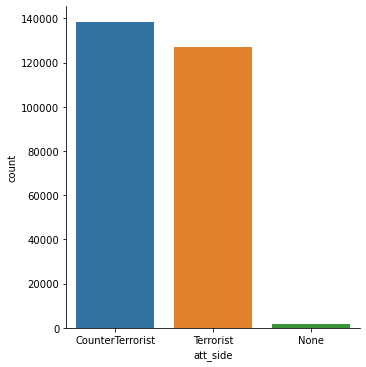

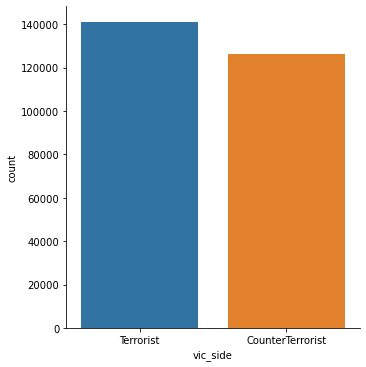

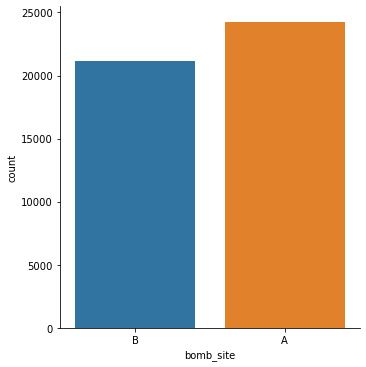

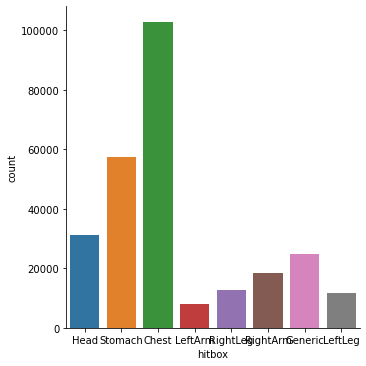

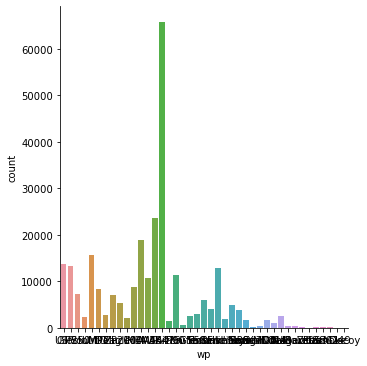

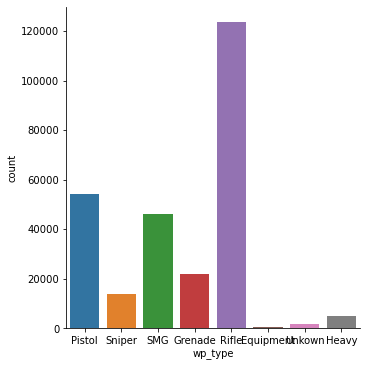

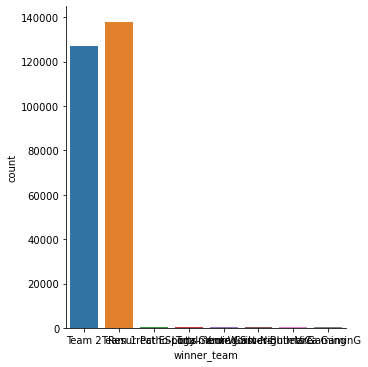

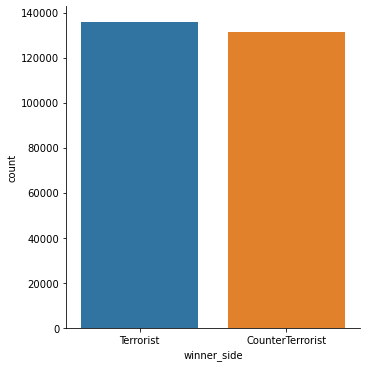

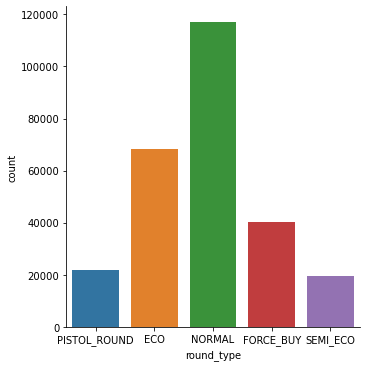

In [182]:
for col in df_cat.columns:
    sns.catplot(x = col, kind = "count", data = df_cat)
    plt.show()

In [101]:
# checking the numerical data
df_num = df.select_dtypes("number")
df_num.head()

,round,tick,seconds,hp_dmg,arm_dmg,award,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,ct_eq_val,t_eq_val,avg_match_rank
0,1,7392,115.9530,100,0,300,76561198115686363,16,76561198370068230,16,-359.5016,389.7257,-468.7209,529.1569,4250,4200,15.0
1,1,7394,115.9842,15,8,300,76561198355692407,17,76561198115686363,16,-650.1707,520.0313,-352.4009,392.1384,4250,4200,15.0
2,1,7404,116.1405,85,0,300,76561198355692407,17,76561198115686363,16,-650.1707,520.0313,-335.1208,401.2988,4250,4200,15.0
3,1,8154,127.8608,100,0,300,76561198152153688,16,76561198301910020,13,-2064.0290,793.1069,-1575.5010,685.9157,4250,4200,15.0
4,1,8162,127.9858,100,0,300,76561198355692407,17,76561198152153688,16,-1090.8520,677.1235,-2063.8480,793.9529,4250,4200,15.0


In [102]:
# ps: numerical columns visualizatiom often crashes the kernel - so it was removed from current version

In [82]:
# we notice that some of the "attacking side" values are not assigned to a team.
# best guess these are collateral damages ("Bomb Blast, Fall Damage").
# decision to remove them from data
df['att_side'].value_counts()

CounterTerrorist    138503
Terrorist           126974
None                  1959
Name: att_side, dtype: int64

In [103]:
df = df[df.att_side != 'None']

In [104]:
#checking for data width
print('hp_dmg', min(df['hp_dmg']), max(df['hp_dmg']))
print('arm_dmg', min(df['arm_dmg']), max(df['arm_dmg']))
print('ct_eq_val', min(df['ct_eq_val']), max(df['ct_eq_val']))
print('t_eq_val', min(df['t_eq_val']), max(df['t_eq_val']))

hp_dmg 0 100
arm_dmg 0 34
ct_eq_val 1000 37450
t_eq_val 1000 35850


In [105]:
# checking entries according to weapon types
df['wp_type'].value_counts()

Rifle        123497
Pistol        54291
SMG           46127
Grenade       22029
Sniper        13698
Heavy          5083
Equipment       749
Name: wp_type, dtype: int64

In [106]:
# removing unknown weapons
df = df[df.wp_type != 'Unkown']

In [107]:
# round_type check
df['round_type'].value_counts()

NORMAL          116226
ECO              67885
FORCE_BUY        40122
PISTOL_ROUND     21743
SEMI_ECO         19498
Name: round_type, dtype: int64

In [108]:
df['bomb_site'].value_counts()
# "bomb_site" presents only a value in case "is_bomb_planted" is TRUE.

# we currently see that there is an even spread between having a bomb planted in Site A or Site B
# yet we can't make use of this info due to the survival bias.
# We only have a view on Terrorist pushes that managed to arrive to a bomb site but not how many attempts there were.

A    23464
B    20363
Name: bomb_site, dtype: int64

In [109]:
# count of matches
print('our df consists of', df['file'].nunique(), 'matches' )

our df consists of 371 matches


In [110]:
# count of rounds
print("our df consists of", df.groupby(['file', 'round']).ngroups, "rounds")

our df consists of 9209 rounds


### Dropping columns

In [111]:
# dropping micro columns - the idea is to focus on round level info rather than in-round events.

df.drop(['date','tick','att_pos_x','att_pos_y','vic_pos_x','vic_pos_y','vic_id','att_team','vic_team','att_id','map','winner_team','award','att_rank','vic_rank','avg_match_rank'], axis=1, inplace=True)
df.drop(['wp','hp_dmg','arm_dmg','bomb_site','vic_side'], axis=1, inplace=True)
df.drop(['seconds','att_side','hitbox','wp_type'], axis=1, inplace=True)

In [114]:
# dropping duplicates on the whole dataframe and adjusting index
df.drop_duplicates(inplace = True, ignore_index = True)

In [115]:
# noticed that there are still multiple entries for each round due to "is_bomb_planted" values
# dropping duplicates while keep the last occurance of "is_bomb_planted = True" if exists
df.drop_duplicates(subset=['file', 'round', 'winner_side','round_type','ct_eq_val','t_eq_val'], keep='last', inplace = True, ignore_index = True)

In [169]:
#df.profile_report()

### Transforming Categorical Data to Numerical

In [118]:
# get dummies
df = pd.get_dummies(df, columns = ['round_type','is_bomb_planted'])

In [119]:
# replacing 'file' entries by a unique simple number + rename column to 'match'
df['file'] = pd.factorize(df.file)[0] + 1
df["file"] = pd.to_numeric(df["file"])
df.rename(columns={'file': 'match'}, inplace=True)

In [120]:
# lowercase all column headers
df.columns = map(str.lower, df.columns)

In [127]:
# df for correlation
df_corr = df.drop(['winner_side', 'match','round'], axis=1)
df_corr.head()

,ct_eq_val,t_eq_val,round_type_eco,round_type_force_buy,round_type_normal,round_type_pistol_round,round_type_semi_eco,is_bomb_planted_false,is_bomb_planted_true
0,4250,4200,0,0,0,1,0,1,0
1,5000,16250,1,0,0,0,0,0,1
2,4250,19350,1,0,0,0,0,0,1
3,16200,22700,0,0,1,0,0,0,1
4,13350,25250,0,1,0,0,0,0,1


### Checking for Correlation

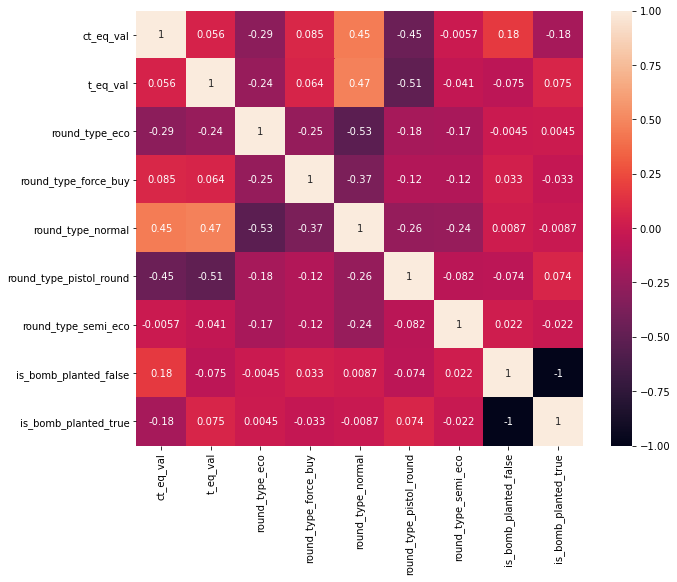

In [170]:
# checking for correlation
corr_matrix=df_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

## Predicting the winner of the round - Modelling

### Logistic Regression Method

In [130]:
X = df_corr
y = df["winner_side"]
X.head()

,ct_eq_val,t_eq_val,round_type_eco,round_type_force_buy,round_type_normal,round_type_pistol_round,round_type_semi_eco,is_bomb_planted_false,is_bomb_planted_true
0,4250,4200,0,0,0,1,0,1,0
1,5000,16250,1,0,0,0,0,0,1
2,4250,19350,1,0,0,0,0,0,1
3,16200,22700,0,0,1,0,0,0,1
4,13350,25250,0,1,0,0,0,0,1


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [132]:
lrc = LogisticRegression(random_state=100, multi_class='ovr', max_iter=1000).fit(X_train, y_train.values.ravel())

In [157]:
def Log_Analisis(lrc, X_test, y_test):
    predictions = lrc.predict(X_test) 
    print("model accuracy: %4.2f " % accuracy_score(y_test, predictions))
    print()
    print(classification_report(y_test, predictions))
    plot_confusion_matrix(lr, X_test, y_test) 
    plt.show()

model accuracy: 0.76 

                  precision    recall  f1-score   support

CounterTerrorist       0.77      0.74      0.76      1504
       Terrorist       0.75      0.79      0.77      1535

        accuracy                           0.76      3039
       macro avg       0.76      0.76      0.76      3039
    weighted avg       0.76      0.76      0.76      3039



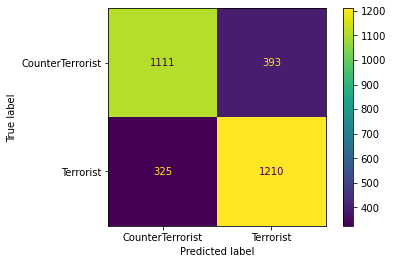

In [158]:
Log_Analisis(lrc, X_test, y_test)

### Random Forest Method

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [160]:
rfc = RandomForestClassifier(random_state=100).fit(X_train, y_train.values.ravel())

model accuracy: 0.72 

                  precision    recall  f1-score   support

CounterTerrorist       0.72      0.71      0.72      1504
       Terrorist       0.72      0.73      0.73      1535

        accuracy                           0.72      3039
       macro avg       0.72      0.72      0.72      3039
    weighted avg       0.72      0.72      0.72      3039



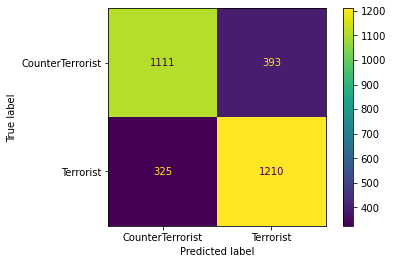

In [161]:
Log_Analisis(rfc, X_test, y_test)

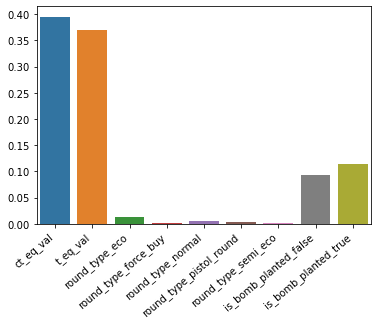

<Figure size 576x288 with 0 Axes>

In [162]:
 # Importance of features in the model
ax = sns.barplot(x = X.columns, y = rfc.feature_importances_)

plt.figure(figsize=(8,4))

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Summary - Prototype Model - Round Winning Side Prediction

As calculated, by diving into data retrieved from 371 matches / 9209 rounds, we have managed as a first step to create a Logistic Regression model that is able to predict with 76% accuracy the winning side of the round.

We can now look forward to the next iteration and building an IGES recommender (see next section).

## Future Project Inspiration:

### Build an IGES recommender (In-Game Economy Strategy Recommender)
Buidling a recommender tool to analyse current match standings and suggest best-in game economy strategy for the next round to maximize match winning success:
- iteratively calculate at each round the probability of success (defined here as winning the match = reaching 16 round wins first) 
- have a model that would, according to user inputs of current team score and round, shoot out current probability of success, and recommend a game economy strategy for the next round for the user's team (example: eco round, force buy round, normal round)

Some suggestions to prototyping on the current dataset:
- retrieve cash award per team due to kills (calculate cumulative damage of victims, any attack taking that damage in the range of 100 should be considered as the kill attack and award the kill reward which is weapon dependent)
- add in the cash reward for winning / losing the game which is streak dependent
- consider remaining alive team members by end of round
- consider team equipment value